In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib
from scipy.signal import find_peaks
from scipy.stats import linregress
import json
matplotlib.rc('axes.formatter', useoffset=False)
# %matplotlib atagg
# matplotlib.use('Qt5Agg')

In [10]:
with open('kali.txt') as json_file:
    kali = json.load(json_file)
print(kali)
def lin_func(x,slope,intercept):
    return slope*x+intercept

{'0': [-0.0006831583189536933, 780.247753204327], '3': [-0.0006593473937488854, 780.247552537188], '4': [-0.0006557151961520067, 780.2473265396443], '5': [-0.0006487626584672954, 780.2472880580533], '6': [-0.0006303134830736428, 780.2472357235326]}


In [35]:
class Spek():
    def __init__(self,freq,cut=False):
        self.freq=freq
        path=f"data/dopplerfrei/{freq}freq.dat"
        path2=f"data/dopplerfrei/{freq}freq_blende.dat"
        self.time, self.U_piezo, self.U_fp, self.U_spek, self.intensity = np.genfromtxt(path).T
        self.time2, self.U_piezo2, self.U_fp2, self.U_spek2, self.intensity2 = np.genfromtxt(path2).T
        # Piezo-Spannung muss noch mit vier multipliziert werden.
        self.U_piezo = 4 * self.U_piezo
        self.U_piezo2 = 4 * self.U_piezo2

        # Falls cut == True, werden die Daten auf eine steigende Flanke der Piezo-Spannung zugeschnitten.
        if cut:
            # Finden des Minimums und Maximums
            # Bei mehreren Minima und Maxima ist die hardgecodete Auswahl über den letzten Index echt unschön...
            min = find_peaks(-1.0*self.U_piezo,width=2000)[0][0]
            max = find_peaks(self.U_piezo,width=2000)[0][-1]

            self.time = self.time[min:max+1]
            self.U_piezo = self.U_piezo[min:max+1]
            self.U_fp = self.U_fp[min:max+1]
            self.U_spek = self.U_spek[min:max+1]
            self.intensity = self.intensity[min:max+1]

            min2 = find_peaks(-1.0*self.U_piezo2,width=2000)[0][0]
            max2 = find_peaks(self.U_piezo2,width=2000)[0][-1]

            self.time2 = self.time2[min2:max2+1]
            self.U_piezo2 = self.U_piezo2[min2:max2+1]
            self.U_fp2 = self.U_fp2[min2:max2+1]
            self.U_spek2 = self.U_spek2[min2:max2+1]
            self.intensity2 = self.intensity2[min2:max2+1]
        self.time=self.time-self.time[0]
        self.time2=self.time2-self.time2[0]
        self.lamb=lin_func(self.U_piezo,kali[str(freq)][0],kali[str(freq)][1])
        self.lamb2=lin_func(self.U_piezo2,kali[str(freq)][0],kali[str(freq)][1])

    
    def plot(self,title=None):
        fig = plt.figure(figsize=(7, 5))
        gs = GridSpec(8, 5)
        fig1 = fig.add_subplot(gs[:, :])
        # fig1.set_title(f"Laser")
        fig1.set_ylabel(r'$U_\mathrm{Spektrum}$ [V]')
        fig1.set_xlabel("t in s")
        # fig1.set_xlim(-5,185)
        # fig1.set_ylim(0,9.5)
        plt.tight_layout()
        plt.plot(self.time,self.U_spek,c="C0")
        plt.plot(self.time2,self.U_spek2,c="C1")
        plt.show()
    def plot_diff(self,title=None):
        fig = plt.figure(figsize=(7, 5))
        gs = GridSpec(8, 5)
        fig1 = fig.add_subplot(gs[:, :])
        # fig1.set_title(f"Laser")
        fig1.set_ylabel(r'$U_\mathrm{Spektrum}$ [V]')
        fig1.set_xlabel("$\lambda$ in nm")
        # fig1.set_xlim(780.246,780.248)
        # fig1.set_ylim(0,9.5)
        plt.tight_layout()
        short=min([len(self.U_spek),len(self.U_spek2),len(self.time)])
        diff=self.U_spek[:short]-self.U_spek2[:short]
        self.peaks_i=find_peaks(diff,prominence=0.1)[0]
        if self.freq==6:
            self.peaks_i=np.delete(self.peaks_i,1)
            self.peaks_i=np.append(self.peaks_i,np.argmin(np.abs(self.time-0.07260)))
        self.peaks_i=np.sort(self.peaks_i)[::-1]
        self.peaks=self.lamb[self.peaks_i]
        print(self.peaks)
        plt.scatter(self.lamb[:short][self.peaks_i],diff[self.peaks_i],c="C1")
        plt.plot(self.lamb[:short],diff,c="C0")
        self.diff=diff
        plt.show()

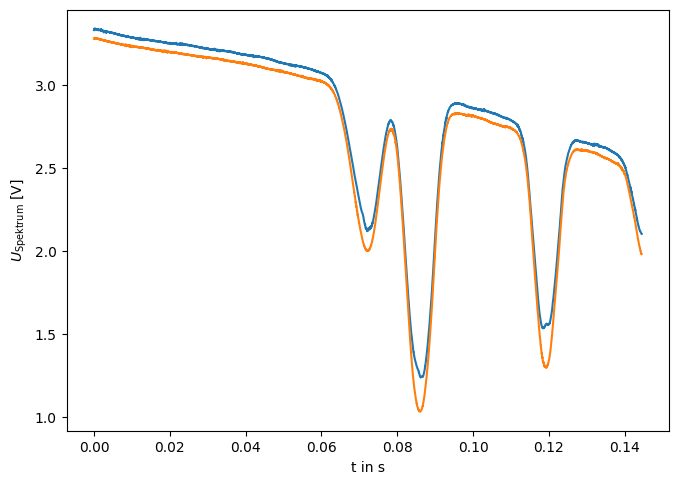

[780.23884463 780.24421329 780.24631314 780.24657654]


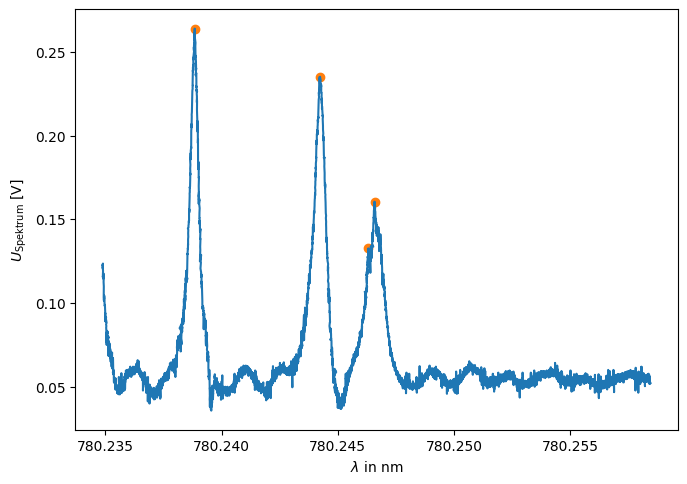

In [43]:
spek3=Spek(6,cut=True)
spek3.plot()
spek3.plot_diff()

In [37]:
peak_lit=780+np.array([.238,.244,.246,.247])
print(peak_lit)
abs_err=(peak_lit-spek3.peaks)
rel_err=(peak_lit-spek3.peaks)/peak_lit
abs_dist=(spek3.peaks[3]-spek3.peaks[0])-(peak_lit[3]-peak_lit[0])
rel_dist=((spek3.peaks[3]-spek3.peaks[0])-(peak_lit[3]-peak_lit[0]))/(peak_lit[3]-peak_lit[0])
print(abs_dist,rel_dist)

[780.238 780.244 780.246 780.247]
-0.0012680831720217611 -0.14089813022619213


In [38]:
peak_heigths_85=spek3.diff[spek3.peaks_i][0]+spek3.diff[spek3.peaks_i][1]
peak_heigths_87=spek3.diff[spek3.peaks_i][3]+spek3.diff[spek3.peaks_i][2]
quot=peak_heigths_87/peak_heigths_85
print(quot)

0.5873978122509138
